In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3070


## load and normalize data

In [4]:
class wineDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        features = self.data[idx]
        return features

In [5]:
class wineDataset2(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        features = self.data[idx][0:11] 
        label = self.data[idx][11]  
        return features, label

In [6]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')

train = pd.concat([X_train, y_train], axis=1)
size = train.shape[0]
scaler = StandardScaler()
scaler.fit(train)
train_scale = scaler.transform(train)

train_dataloader = DataLoader(wineDataset(train_scale), batch_size=size, shuffle=True)


In [7]:
next(enumerate(train_dataloader))[1][0]

tensor([ 0.5964,  1.0904, -0.1395, -0.3190, -0.3530, -1.0733, -0.7996, -0.0443,
        -1.2589, -0.4170, -0.5319, -0.7873], dtype=torch.float64)

## define model

In [8]:
noise_len = 100

In [115]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(noise_len, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 12),
            nn.ReLU()
        )

    def forward(self, input):
        return self.gen(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
    def forward(self, input):
        return self.dis(input)
        

## initialize training

In [207]:
netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

real_label = torch.ones((size, 1), dtype=torch.float32, device=device)
fake_label = torch.zeros((size, 1), dtype=torch.float32, device=device)

G_losses = []
D_losses = []

## train

In [117]:
lr = 0.0002
num_epoch = 100

optimizerD = optim.Adam(netD.parameters(), lr=lr, weight_decay=0)
optimizerG = optim.Adam(netG.parameters(), lr=lr, weight_decay=0)

### train discriminator

In [214]:
for epoch in range(num_epoch):
    for i, data in enumerate(train_dataloader):
        
        # real data
        netD.zero_grad()
        data = data.to(torch.float32).to(device)
        
        output = netD(data)

        errD_real = criterion(output, real_label)
        errD_real.backward()
        D_x = output.mean().item()

        # fake data
        noise = torch.randn(size, noise_len, device=device)
        fake = netG(noise)
        
        output = netD(fake)

        errD_fake = criterion(output, fake_label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        D_losses.append(errD.item())
        
    if epoch % 5 == 0:
        print('[%d/%d]\tLoss_D: %.4f\tReal mean: %.4f\tFake mean: %.4f' % (epoch, num_epoch, errD.item(), D_x, D_G_z1))





[0/100]	Loss_D: 1.3826	Real mean: 0.4941	Fake mean: 0.4918
[5/100]	Loss_D: 1.3824	Real mean: 0.4941	Fake mean: 0.4917
[10/100]	Loss_D: 1.3823	Real mean: 0.4941	Fake mean: 0.4917
[15/100]	Loss_D: 1.3823	Real mean: 0.4941	Fake mean: 0.4917
[20/100]	Loss_D: 1.3822	Real mean: 0.4941	Fake mean: 0.4916
[25/100]	Loss_D: 1.3823	Real mean: 0.4941	Fake mean: 0.4917
[30/100]	Loss_D: 1.3824	Real mean: 0.4941	Fake mean: 0.4917
[35/100]	Loss_D: 1.3824	Real mean: 0.4941	Fake mean: 0.4917
[40/100]	Loss_D: 1.3824	Real mean: 0.4941	Fake mean: 0.4917
[45/100]	Loss_D: 1.3827	Real mean: 0.4941	Fake mean: 0.4919
[50/100]	Loss_D: 1.3825	Real mean: 0.4941	Fake mean: 0.4918
[55/100]	Loss_D: 1.3826	Real mean: 0.4941	Fake mean: 0.4918
[60/100]	Loss_D: 1.3824	Real mean: 0.4941	Fake mean: 0.4917
[65/100]	Loss_D: 1.3827	Real mean: 0.4941	Fake mean: 0.4918
[70/100]	Loss_D: 1.3822	Real mean: 0.4941	Fake mean: 0.4916
[75/100]	Loss_D: 1.3824	Real mean: 0.4941	Fake mean: 0.4917
[80/100]	Loss_D: 1.3822	Real mean: 0.4941	

### train generator

In [215]:
for epoch in range(num_epoch):
    for i, data in enumerate(train_dataloader, 0):

        netG.zero_grad()
        
        noise = torch.randn(size, noise_len, device=device)
        fake = netG(noise)
        output = netD(fake)
        
        errG = criterion(output, real_label)
        errG.backward()
        
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_losses.append(errG.item())

    if epoch % 5 == 0:
        print('[%d/%d]\tLoss_G: %.4f\tFake mean: %.4f' % (epoch, num_epoch, errG.item(), D_G_z2))





[0/100]	Loss_G: 0.7100	Fake mean: 0.4916
[5/100]	Loss_G: 0.7098	Fake mean: 0.4917
[10/100]	Loss_G: 0.7099	Fake mean: 0.4917
[15/100]	Loss_G: 0.7095	Fake mean: 0.4919
[20/100]	Loss_G: 0.7095	Fake mean: 0.4919
[25/100]	Loss_G: 0.7097	Fake mean: 0.4918
[30/100]	Loss_G: 0.7100	Fake mean: 0.4917
[35/100]	Loss_G: 0.7096	Fake mean: 0.4919
[40/100]	Loss_G: 0.7099	Fake mean: 0.4917
[45/100]	Loss_G: 0.7096	Fake mean: 0.4918
[50/100]	Loss_G: 0.7097	Fake mean: 0.4918
[55/100]	Loss_G: 0.7098	Fake mean: 0.4917
[60/100]	Loss_G: 0.7099	Fake mean: 0.4917
[65/100]	Loss_G: 0.7099	Fake mean: 0.4917
[70/100]	Loss_G: 0.7096	Fake mean: 0.4918
[75/100]	Loss_G: 0.7098	Fake mean: 0.4918
[80/100]	Loss_G: 0.7098	Fake mean: 0.4918
[85/100]	Loss_G: 0.7100	Fake mean: 0.4916
[90/100]	Loss_G: 0.7099	Fake mean: 0.4917
[95/100]	Loss_G: 0.7098	Fake mean: 0.4917


## generate 

In [216]:

with torch.no_grad():
    noise = torch.randn(3000, noise_len, device=device)
    fake = netG(noise).cpu()
    fake = scaler.inverse_transform(fake)

fake = pd.DataFrame(fake).round(3)
fake.head(10)


,0,1,2,3,4,5,6,7,8,9,10,11
0,8.516,0.526,0.267,2.519,0.086,15.836,46.204,0.997,3.317,0.672,10.580,5.636
1,8.808,0.526,0.267,2.519,0.089,15.836,46.855,0.997,3.317,0.680,10.475,5.705
2,8.746,0.526,0.267,2.519,0.090,15.836,47.790,0.997,3.317,0.659,10.659,5.713
3,8.447,0.526,0.267,2.519,0.088,15.922,50.200,0.997,3.317,0.682,10.475,5.676
4,8.310,0.526,0.287,2.519,0.086,15.836,47.744,0.997,3.317,0.701,10.475,5.646
5,8.501,0.526,0.267,2.519,0.086,15.836,50.873,0.997,3.335,0.670,10.518,5.747
6,8.477,0.526,0.271,2.519,0.086,15.836,48.585,0.997,3.317,0.703,10.475,5.721
7,8.627,0.526,0.267,2.519,0.090,15.836,46.204,0.997,3.317,0.676,10.525,5.636
8,8.518,0.526,0.267,2.519,0.089,15.836,49.210,0.997,3.317,0.674,10.475,5.683
9,8.711,0.526,0.267,2.519,0.086,15.836,46.204,0.997,3.317,0.658,10.564,5.707


In [186]:
pd.DataFrame(train.values.round(3)).head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
0,7.8,0.500,0.17,1.6,0.082,21.0,102.0,0.996,3.39,0.48,9.5,5.0
1,7.6,0.290,0.49,2.7,0.092,25.0,60.0,0.997,3.31,0.61,10.1,6.0
2,6.9,0.400,0.24,2.5,0.083,30.0,45.0,0.996,3.26,0.58,10.0,5.0
3,8.9,0.635,0.37,1.7,0.263,5.0,62.0,0.997,3.00,1.09,9.3,5.0
4,9.4,0.300,0.56,2.8,0.080,6.0,17.0,0.996,3.15,0.92,11.7,8.0
5,8.0,0.710,0.00,2.6,0.080,11.0,34.0,0.998,3.44,0.53,9.5,5.0
6,7.8,0.410,0.68,1.7,0.467,18.0,69.0,0.997,3.08,1.31,9.3,5.0
7,8.4,0.340,0.42,2.1,0.072,23.0,36.0,0.994,3.11,0.78,12.4,6.0
8,6.3,0.760,0.00,2.9,0.072,26.0,52.0,0.994,3.51,0.60,11.5,6.0
9,7.7,0.835,0.00,2.6,0.081,6.0,14.0,0.998,3.30,0.52,9.3,5.0


## save model

In [1820]:
torch.save(netD.state_dict(), './model/netD.pt')
torch.save(netG.state_dict(), './model/netG.pt')

## load model

In [ ]:
netD = Discriminator()
netD.load_state_dict(torch.load('./model/netD.pt'))

netG = Generator()
netG.load_state_dict(torch.load('./model/netG.pt'))

In [189]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [217]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')['quality'].values
X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')['quality'].values

In [218]:
X_fake = fake.iloc[:, 0:11]
y_fake = fake.iloc[:, 11].round().clip(3, 8)
X_aug = np.concatenate((X_fake.values, X_train.values))
y_aug = np.concatenate((y_fake, y_train))

In [219]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(X_aug, y_aug)

logreg = make_pipeline(StandardScaler(), LogisticRegression(random_state=16, max_iter=6000))
logreg.fit(X_aug, y_aug)

X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')['quality'].values
X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')['quality'].values

c:\Users\jinjinran\Documents\GitHub\Datathon\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\jinjinran\Documents\GitHub\Datathon\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\jinjinran\Documents\GitHub\Datathon\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\jinjinran\Documents\GitHub\Datathon\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


auc svm: 0.758695558726525
accuracy svm: 0.625


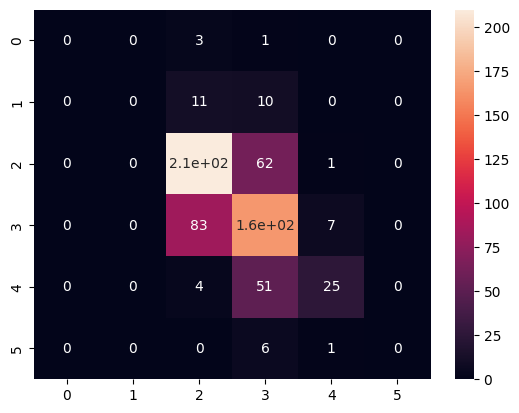

log auc: 0.7837947832650242
log accuracy: 0.5640625


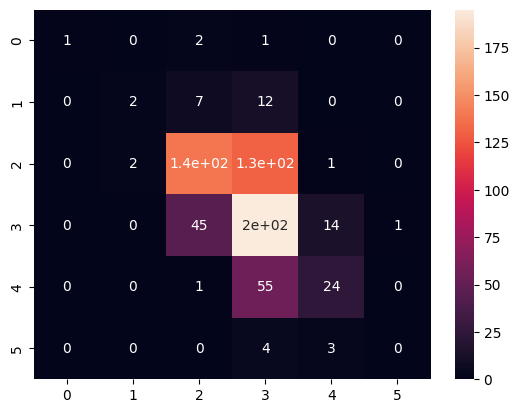

In [220]:
y_test_predict = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

y_test_predict_log = logreg.predict(X_test)
y_test_pred_prob_log = logreg.predict_proba(X_test)

sns.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)

print('auc svm:', roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr'))
print('accuracy svm:', accuracy_score(y_test, y_test_predict))
plt.show()

sns.heatmap(confusion_matrix(y_test, y_test_predict_log), annot=True)

print('log auc:', roc_auc_score(y_test, y_test_pred_prob_log, multi_class='ovr'))
print('log accuracy:', accuracy_score(y_test, y_test_predict_log))

In [ ]:
# 61 svm 60 log for original data